# DETECT ANOMALIES IN STOCK PRICES USING LONG SHORT-TERM MEMORY (LSTM)
## Applications:

*   Trading: Use anomaly detection for trading strategies and risk management
*   Banks and Regulators: Spot fraudulent activities and insider trading


In [17]:
# Import libraries
import pandas as pd
import plotly.express as px
from copy import copy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import plotly.figure_factory as ff
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import datetime
import yfinance as yf
from tensorflow import keras

In [18]:
# Download stock prices from 2015 to the current stock price
ticker = ['TSLA']
df_prices = pd.DataFrame()

start_date = "2015-01-01"
end_date = datetime.date.today()
stock_prices = yf.download(ticker, start_date, end_date, progress = False)

stock_prices.columns = stock_prices.columns.droplevel(1)  # Drop the "Ticker" level

stock_prices = stock_prices.reset_index()
df_prices["Date"] = stock_prices["Date"]
df_prices["Close"] = stock_prices["Close"]
df_prices

,Date,Close
0,2015-01-02,14.620667
1,2015-01-05,14.006000
2,2015-01-06,14.085333
3,2015-01-07,14.063333
4,2015-01-08,14.041333
...,...,...
2554,2025-02-28,292.980011
2555,2025-03-03,284.649994
2556,2025-03-04,272.040009
2557,2025-03-05,279.100006


In [19]:
# Plot interactive chart for original closing prices
fig = px.line(title= ticker[0] + "Stock Prices")
fig.add_scatter(x = df_prices['Date'],y = df_prices["Close"])
fig.update_layout(
    autosize=True,
    title_font_size=20,
    xaxis_title="Date",
    yaxis_title="Price ($)",
    legend_title="Price Type",
)
fig.show()

In [20]:
prices = df_prices[['Close']].values # get the closing prices in 2-D array
prices

array([[ 14.62066746],
       [ 14.00599957],
       [ 14.08533287],
       ...,
       [272.04000854],
       [279.1000061 ],
       [263.45001221]])

In [21]:
# Normalize stock prices
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

In [22]:
X = [] # input features
y = [] # target labels

sequence_length = 50  # Use past 50 days to predict next day
for i in range(sequence_length, len(prices_scaled)):
    X.append(prices_scaled[i-sequence_length:i, 0])
    y.append(prices_scaled[i, 0])

In [23]:
# Convert the data into array format
X = np.asarray(X)
y = np.asarray(y)

In [24]:
# Split the data into training (70%) and testing data (30%)
split = int(0.7 * len(X))
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [25]:
# Reshape the 1D arrays to 3D arrays to feed in the model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train.shape, X_test.shape

((1756, 50, 1), (753, 50, 1))

In [26]:
# Create the model
inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])) # the input parameters are the dimensions of the array
# Set the return_sequence to true as to return the last output or not for sorting out the dimension problem
x = keras.layers.LSTM(150, return_sequences= True)(inputs) # set 150 neutrons for the LSTM layer.
x = keras.layers.Dropout(0.2)(x) #The dropout rate is the percentage of neurons that are randomly dropped during training for better generalization
x = keras.layers.LSTM(150, return_sequences=True)(x) # the inputs of the 2nd layer is x from the previous layer and so on
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss="mse") # adam is the most common optimizer
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 50, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50, 150)             │          91,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 150)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 50, 150)             │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50, 150)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 150)                 │         180,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 452,551 (1.73 MB)

 Trainable params: 452,551 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Fitting the model with the training data
# Add EarlyStopping to prevent overfitting
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - loss: 3.4652e-04 - val_loss: 0.0670
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - loss: 0.0038 - val_loss: 0.0300
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - loss: 0.0070 - val_loss: 0.0091
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - loss: 0.0179 - val_loss: 0.0288
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - loss: 0.0074 - val_loss: 0.0027
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 0.0011 - val_loss: 0.0129
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - loss: 0.0010 - val_loss: 0.0250
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - loss: 5.8887e-04 - val_loss: 0.0025
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - loss: 0.0031 - val_loss: 0.1055
Epoch 10/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - loss: 0.0094 - val_loss: 0.0734
Epoch 11/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - loss: 0.0159 - val_loss: 0.0395


In [28]:
# Make prediction
predicted_train = model.predict(X_train, verbose=0)
predicted_train.shape

(1756, 1)

In [29]:
# Reshape it to 2D array for comparison which becomes (samples, time_steps*features)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  
X_train_reshaped.shape

(1756, 50)

Reconstruction error threshold:  0.26998303475831825


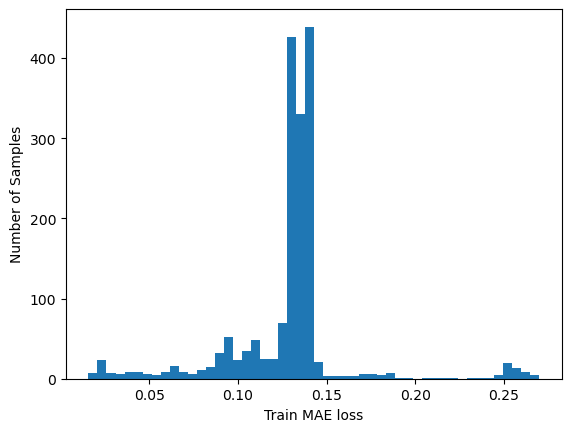

In [30]:
train_mae_loss = np.mean(np.abs(predicted_train - X_train_reshaped), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss) # set the threshold of the anomaly to the max of MAE of the training dataset
#threshold = np.percentile(train_mae_loss, 99)  # Top 1% as anomalies
print("Reconstruction error threshold: ",threshold)

In [31]:
test_anomaly = df_prices[split+sequence_length:][['Date']]
test_anomaly

,Date
1806,2022-03-07
1807,2022-03-08
1808,2022-03-09
1809,2022-03-10
1810,2022-03-11
...,...
2554,2025-02-28
2555,2025-03-03
2556,2025-03-04
2557,2025-03-05


In [33]:
predicted_test = model.predict(X_test, verbose=0)
# Reshape it to 2D array for comparison which becomes (samples, time_steps*features)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)  
X_test_reshaped.shape
test_mae_loss = np.mean(np.abs(predicted_test-X_test_reshaped), axis=1)

In [34]:
test_anomaly['Close'] = df_prices[split+sequence_length:]['Close']
test_anomaly['Loss'] = test_mae_loss
test_anomaly['Threshold'] = threshold
test_anomaly['Anomaly'] = test_anomaly['Loss'] > test_anomaly['Threshold']

In [35]:
anomalies = test_anomaly.loc[test_anomaly['Anomaly'] == True]
anomalies

,Date,Close,Loss,Threshold,Anomaly
2534,2025-01-30,400.279999,0.274567,0.269983,True
2535,2025-01-31,404.600006,0.280827,0.269983,True
2536,2025-02-03,383.679993,0.285967,0.269983,True
2537,2025-02-04,392.209991,0.290077,0.269983,True
2538,2025-02-05,378.170013,0.294138,0.269983,True
2539,2025-02-06,374.320007,0.298397,0.269983,True
2540,2025-02-07,361.619995,0.303153,0.269983,True
2541,2025-02-10,350.730011,0.307780,0.269983,True
2542,2025-02-11,328.500000,0.313628,0.269983,True
2543,2025-02-12,336.510010,0.320349,0.269983,True


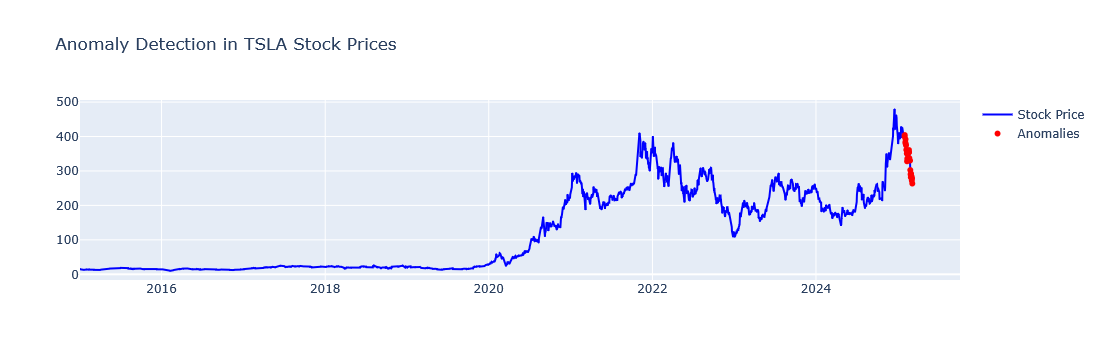

In [36]:
# Plot interactive chart of stock prices and anomalies

fig = px.line(title= "Anomaly Detection in " + ticker[0] + " Stock Prices") # add title

fig.add_scatter(x = df_prices['Date'],y = df_prices["Close"], mode = 'lines', name = 'Stock Price', marker=dict(color='blue')) # plot the chart of stock prices
fig.add_scatter(x = anomalies['Date'],y = anomalies["Close"], mode='markers', name='Anomalies', marker=dict(color='red')) # spot the anomalies

fig.show()

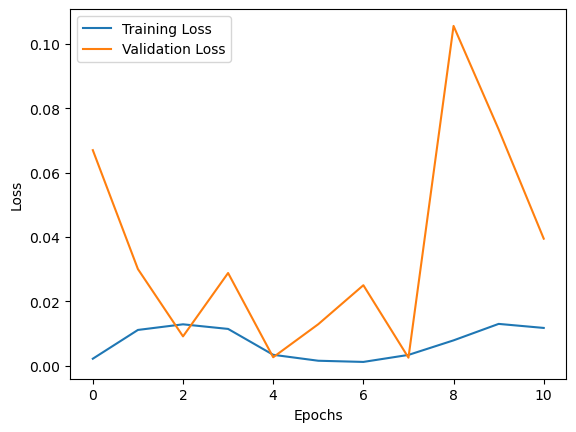

In [37]:
# Plot the graphs of training loss and validation loss,
# Both curves show a steady decline in loss and coverage to the min, a sign of good generalization of the LSTM model
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
df = df_prices.copy()
df['SMA_50'] = df_prices['Close'].rolling(window=50).mean()  # 50-day SMA
df['SMA_200'] = df_prices['Close'].rolling(window=200).mean()  # 200-day SMA

# Show the last few rows
print(df.tail())

           Date       Close      SMA_50    SMA_200
2554 2025-02-28  292.980011  389.279799  278.76415
2555 2025-03-03  284.649994  385.712399  279.32795
2556 2025-03-04  272.040009  381.555999  279.80040
2557 2025-03-05  279.100006  378.335399  280.32595
2558 2025-03-06  263.450012  374.880999  280.76900


In [39]:
# Calculate the MAE and RMSE of the predicted values of the test dataset
# Descaling the MAE and RMSE, the error of predicting the actual stock price is around $17, which is around 5% of the SMA and is considered to be good.
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(predicted_test.reshape(-1), y_test.reshape(-1))
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(predicted_test.reshape(-1), y_test.reshape(-1)))
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.13026008526602864
Root Mean Squared Error (RMSE): 0.1519955823410622
